# COVID-19 Clinical Trials — EDA + Simple ML

**Project goal:** Clean the dataset, perform exploratory data analysis (EDA), and build a simple model to predict trial `Status` using common fields. This notebook is compact and suitable for an internship portfolio.

## 1. Setup
Import libraries and load the CSV.

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
pd.set_option('display.max_columns', None)

DATA_PATH = Path('data') / 'covid_clinical_trials.csv'
df = pd.read_csv(DATA_PATH, low_memory=False)
df.shape


(5783, 27)

## 2. Quick data peek

In [2]:
df.head()


,Rank,NCT Number,Title,Acronym,Status,Study Results,Conditions,Interventions,Outcome Measures,Sponsor/Collaborators,Gender,Age,Phases,Enrollment,Funded Bys,Study Type,Study Designs,Other IDs,Start Date,Primary Completion Date,Completion Date,First Posted,Results First Posted,Last Update Posted,Locations,Study Documents,URL
0,1,NCT04785898,Diagnostic Performance of the ID Now™ COVID-19...,COVID-IDNow,"Active, not recruiting",No Results Available,Covid19,Diagnostic Test: ID Now™ COVID-19 Screening Test,Evaluate the diagnostic performance of the ID ...,Groupe Hospitalier Paris Saint Joseph,All,"18 Years and older (Adult, Older Adult)",Not Applicable,1000.0,Other,Interventional,Allocation: N/A|Intervention Model: Single Gro...,COVID-IDNow,"November 9, 2020","December 22, 2020","April 30, 2021","March 8, 2021",NaN,"March 8, 2021","Groupe Hospitalier Paris Saint-Joseph, Paris, ...",NaN,https://ClinicalTrials.gov/show/NCT04785898
1,2,NCT04595136,Study to Evaluate the Efficacy of COVID19-0001...,COVID-19,Not yet recruiting,No Results Available,SARS-CoV-2 Infection,Drug: Drug COVID19-0001-USR|Drug: normal saline,Change on viral load results from baseline aft...,United Medical Specialties,All,"18 Years and older (Adult, Older Adult)",Phase 1|Phase 2,60.0,Other,Interventional,Allocation: Randomized|Intervention Model: Par...,COVID19-0001-USR,"November 2, 2020","December 15, 2020","January 29, 2021","October 20, 2020",NaN,"October 20, 2020","Cimedical, Barranquilla, Atlantico, Colombia",NaN,https://ClinicalTrials.gov/show/NCT04595136
2,3,NCT04395482,Lung CT Scan Analysis of SARS-CoV2 Induced Lun...,TAC-COVID19,Recruiting,No Results Available,covid19,Other: Lung CT scan analysis in COVID-19 patients,A qualitative analysis of parenchymal lung dam...,University of Milano Bicocca,All,"18 Years and older (Adult, Older Adult)",NaN,500.0,Other,Observational,Observational Model: Cohort|Time Perspective: ...,TAC-COVID19,"May 7, 2020","June 15, 2021","June 15, 2021","May 20, 2020",NaN,"November 9, 2020","Ospedale Papa Giovanni XXIII, Bergamo, Italy|P...",NaN,https://ClinicalTrials.gov/show/NCT04395482
3,4,NCT04416061,The Role of a Private Hospital in Hong Kong Am...,COVID-19,"Active, not recruiting",No Results Available,COVID,Diagnostic Test: COVID 19 Diagnostic Test,Proportion of asymptomatic subjects|Proportion...,Hong Kong Sanatorium & Hospital,All,"Child, Adult, Older Adult",NaN,2500.0,Industry,Observational,Observational Model: Cohort|Time Perspective: ...,RC-2020-08,"May 25, 2020","July 31, 2020","August 31, 2020","June 4, 2020",NaN,"June 4, 2020","Hong Kong Sanatorium & Hospital, Hong Kong, Ho...",NaN,https://ClinicalTrials.gov/show/NCT04416061
4,5,NCT04395924,Maternal-foetal Transmission of SARS-Cov-2,TMF-COVID-19,Recruiting,No Results Available,Maternal Fetal Infection Transmission|COVID-19...,Diagnostic Test: Diagnosis of SARS-Cov2 by RT-...,COVID-19 by positive PCR in cord blood and / o...,Centre Hospitalier Régional d'Orléans|Centre d...,Female,18 Years to 48 Years (Adult),NaN,50.0,Other,Observational,Observational Model: Cohort|Time Perspective: ...,CHRO-2020-10,"May 5, 2020",May 2021,May 2021,"May 20, 2020",NaN,"June 4, 2020","CHR Orléans, Orléans, France",NaN,https://ClinicalTrials.gov/show/NCT04395924


## 3. Columns & basic info

In [3]:
df.info()

# show a quick count of nulls
(df.isnull().mean()*100).sort_values(ascending=False).head(15)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5783 entries, 0 to 5782
Data columns (total 27 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Rank                     5783 non-null   int64  
 1   NCT Number               5783 non-null   object 
 2   Title                    5783 non-null   object 
 3   Acronym                  2480 non-null   object 
 4   Status                   5783 non-null   object 
 5   Study Results            5783 non-null   object 
 6   Conditions               5783 non-null   object 
 7   Interventions            4897 non-null   object 
 8   Outcome Measures         5748 non-null   object 
 9   Sponsor/Collaborators    5783 non-null   object 
 10  Gender                   5773 non-null   object 
 11  Age                      5783 non-null   object 
 12  Phases                   3322 non-null   object 
 13  Enrollment               5749 non-null   float64
 14  Funded Bys              

Results First Posted       99.377486
Study Documents            96.852845
Acronym                    57.115684
Phases                     42.555767
Interventions              15.320768
Locations                  10.115857
Completion Date             0.622514
Primary Completion Date     0.622514
Study Designs               0.605222
Outcome Measures            0.605222
Enrollment                  0.587930
Start Date                  0.587930
Gender                      0.172921
Other IDs                   0.017292
Last Update Posted          0.000000
dtype: float64

## 4. Cleaning (minimal and explainable)
- Drop obviously useless columns (URL, NCT Number)
- Fill categorical missing values with a `Missing_` marker
- Impute numeric `Enrollment` with median
- Extract `Country` from `Locations` if available

In [4]:
# Keep a copy
orig = df.copy()

# Drop columns that are identifiers or too long for this compact project
drop_cols = [c for c in ['NCT Number','URL','Study Documents'] if c in df.columns]
df = df.drop(columns=[c for c in drop_cols if c in df.columns])

# Make Country feature from Locations
if 'Locations' in df.columns:
    df['Country'] = df['Locations'].astype(str).apply(lambda x: x.split(',')[-1].strip() if pd.notna(x) and ',' in x else (x.strip() if pd.notna(x) else 'Missing_Location'))

# Fill categorical missing with 'Missing_<col>'
cat_cols = df.select_dtypes(include=['object']).columns.tolist()
for c in cat_cols:
    df[c] = df[c].fillna(f'Missing_{c}')

# Enrollment median fill
if 'Enrollment' in df.columns:
    df['Enrollment'] = pd.to_numeric(df['Enrollment'], errors='coerce')
    med = df['Enrollment'].median()
    df['Enrollment'] = df['Enrollment'].fillna(med)

# Simplify Status: keep top 3 statuses, map others to 'Other'
top_status = df['Status'].value_counts().index[:3].tolist()
df['Status_simple'] = df['Status'].apply(lambda x: x if x in top_status else 'Other')

print('After cleaning shape:', df.shape)
df['Status_simple'].value_counts()


After cleaning shape: (5783, 26)


Status_simple
Recruiting            2805
Completed             1025
Not yet recruiting    1004
Other                  949
Name: count, dtype: int64

## 5. EDA visualizations (simple counts)
We'll show counts for Status, Phases, Country (top 10), and Enrollment distribution.

Plots generated


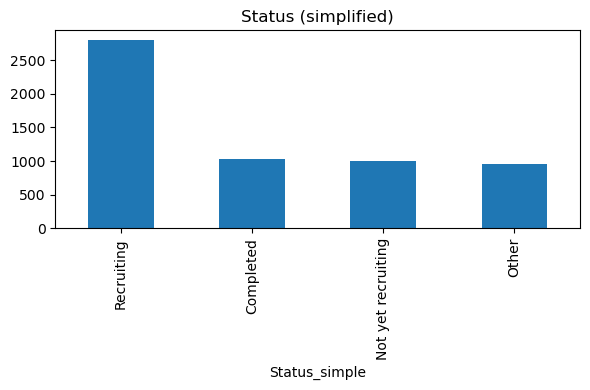

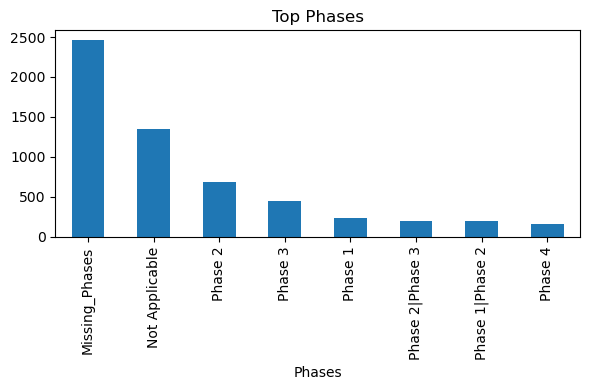

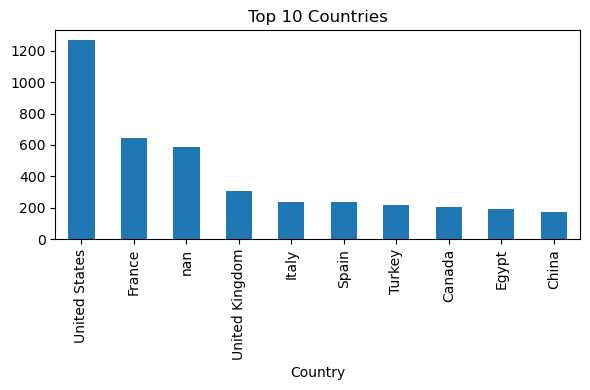

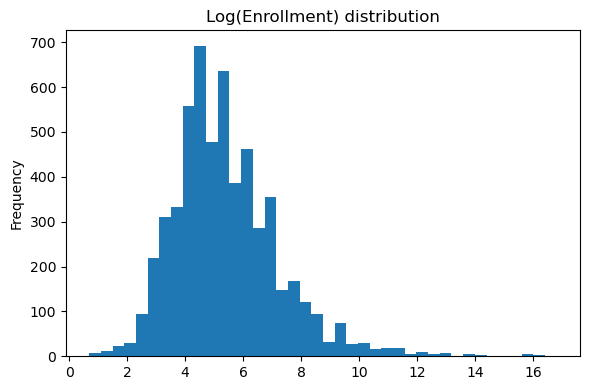

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
df['Status_simple'].value_counts().plot(kind='bar')
plt.title('Status (simplified)')
plt.tight_layout()

plt.figure(figsize=(6,4))
df['Phases'].fillna('Missing_Phases').value_counts().head(8).plot(kind='bar')
plt.title('Top Phases')
plt.tight_layout()

plt.figure(figsize=(6,4))
df['Country'].value_counts().head(10).plot(kind='bar')
plt.title('Top 10 Countries')
plt.tight_layout()

plt.figure(figsize=(6,4))
df['Enrollment'].replace(0, np.nan).dropna().map(lambda x: np.log1p(x)).plot(kind='hist', bins=40)
plt.title('Log(Enrollment) distribution')
plt.tight_layout()

print('Plots generated')


## 6. Feature selection for ML
We'll use a small set of features:
- Enrollment (numeric)
- Phases (categorical)
- Study Type (categorical)
- Country (categorical)
- Gender (categorical)
Target: `Status_simple` (3 frequent classes + Other)

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

features = []
for c in ['Enrollment','Phases','Study Type','Country','Gender']:
    if c in df.columns:
        features.append(c)

X = df[features].copy()
y = df['Status_simple'].copy()

# Drop rows where target is missing (shouldn't be) and small safety
mask = y.notna()
X = X[mask]; y = y[mask]

# Simple split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

# Preprocessing
num_features = [f for f in features if X[f].dtype in [int,float] or f=='Enrollment']
cat_features = [f for f in features if f not in num_features]

num_pipeline = Pipeline([('imputer', SimpleImputer(strategy='median')),('scaler', StandardScaler())])
cat_pipeline = Pipeline([('imputer', SimpleImputer(strategy='constant', fill_value='Missing_cat')),('ohe', OneHotEncoder(handle_unknown='ignore'))])

preproc = ColumnTransformer([('num', num_pipeline, num_features),('cat', cat_pipeline, cat_features)])

clf = Pipeline([('preproc', preproc),('model', RandomForestClassifier(n_estimators=100, random_state=42))])

clf.fit(X_train, y_train)

pred = clf.predict(X_test)
print('Accuracy:', accuracy_score(y_test, pred))
print('\nClassification report:\n')
print(classification_report(y_test, pred))


Accuracy: 0.520746887966805

Classification report:

                    precision    recall  f1-score   support

         Completed       0.34      0.27      0.30       256
Not yet recruiting       0.62      0.57      0.60       251
             Other       0.35      0.23      0.28       237
        Recruiting       0.57      0.69      0.62       702

          accuracy                           0.52      1446
         macro avg       0.47      0.44      0.45      1446
      weighted avg       0.50      0.52      0.51      1446



## 7. Short conclusions & next steps
- Briefly summarize model performance and suggestions for improvement (feature engineering, more advanced models, text features).

In [7]:
print('Top 5 feature names from one-hot (approx):')
# Get feature names from preprocessor
try:
    ohe = clf.named_steps['preproc'].named_transformers_['cat'].named_steps['ohe']
    cat_cols = clf.named_steps['preproc'].transformers_[1][2]
    # approximate, printing categories
    print('Categorical feature categories (sample):')
    for name, cats in zip(cat_cols, ohe.categories_):
        print(name, '->', cats[:5])
except Exception as e:
    print('Could not print OHE categories:', e)

print('\nNotebook complete. Save and inspect results.')


Top 5 feature names from one-hot (approx):
Categorical feature categories (sample):
Phases -> ['Early Phase 1' 'Missing_Phases' 'Not Applicable' 'Phase 1'
 'Phase 1|Phase 2']
Study Type -> ['Expanded Access' 'Expanded Access:Individual Patients'
 'Expanded Access:Individual Patients|Intermediate-size Population'
 'Expanded Access:Individual Patients|Treatment IND/Protocol'
 'Expanded Access:Intermediate-size Population']
Country -> ['Albania' 'Argentina' 'Australia' 'Austria' 'Azerbaijan']
Gender -> ['All' 'Female' 'Male' 'Missing_Gender']

Notebook complete. Save and inspect results.
